In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Physical constraints
E = 1000  # Relative tensile modululs
t = 1.2  # Spring thickness

n = 200  # Number of spring elements to compute
keep_out_penalty = 1e9

neutral_roller_center = np.array([17.58, -7.2])
deflected_roller_center = np.array([18.62, 3.78])
shaft_center = np.array([0, 0])

roller_radius = 8
shaft_radius = 5.5

rolling_end_neutral_angle = 13.58 * np.pi / 180
rolling_end_deflected_angle = 89 * np.pi / 180

fixed_end_domain_length = 6
rolling_end_domain_length = 8.1

In [3]:
def keep_out_check(r, origin, radius):
    return np.sum((r - origin)**2, axis=1) < radius**2

def fixed_end(x):
    return np.array([-2 + fixed_end_domain_length*x, -9.56])

def rolling_end_neutral(x):
    return np.array([13.7 + x*rolling_end_domain_length*np.cos(rolling_end_neutral_angle), 
                     1 + x*rolling_end_domain_length*np.sin(rolling_end_neutral_angle)])

def rolling_end_deflected(x):
    return np.array([9.7 + x*rolling_end_domain_length*np.cos(rolling_end_deflected_angle),  
                     2.1 + x*rolling_end_domain_length*np.sin(rolling_end_deflected_angle)])

In [4]:
#  Neutral spring postion initial guess
guess_r0 = np.zeros([n, 2])
guess_r0[:, 0] = np.linspace(1, 13.7, num=n+1, endpoint=False)[1:]
guess_r0[:, 1] = (guess_r0[:, 0] - 13.7) * (10.56 / 12.7) + 1
#  Deflected spring position initial guess
guess_r1 = np.zeros_like(guess_r0)
guess_r1[:, 0] = np.linspace(1, 9.7, num=n+1, endpoint=False)[1:]
guess_r1[:, 1] = (guess_r1[:, 0] - 9.7) * (11.66 / 8.7) + 2.1

#  Initital Guess
x0 = np.zeros(4*n+2)
x0[-1] = 0.5
x0[-2] = 0
x0[:n] = guess_r0[:, 0]
x0[n:2*n] = guess_r0[:, 1]
x0[2*n:3*n] = guess_r1[:, 0]
x0[3*n:4*n] = guess_r1[:, 1]

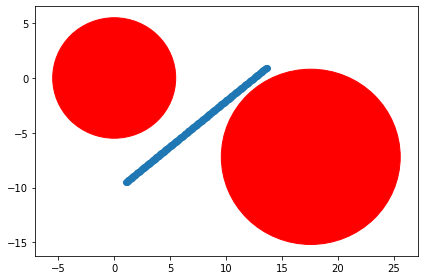

In [5]:
#  Plot the initial guess and keep out zones
shaft_circle = plt.Circle(shaft_center, shaft_radius, color='r')
neutral_roller_circle = plt.Circle(neutral_roller_center, roller_radius, color='r')

plt.close()
fig, ax = plt.subplots()
plt.scatter(guess_r0[:, 0], guess_r0[:, 1])
ax.add_patch(shaft_circle)
ax.add_patch(neutral_roller_circle)
plt.title("Neutral Spring Initial Guess")
plt.tight_layout()

plt.show()

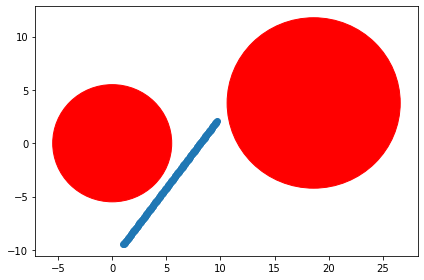

In [7]:
shaft_circle = plt.Circle(shaft_center, shaft_radius, color='r')
deflected_roller_circle = plt.Circle(deflected_roller_center, roller_radius, color='r')

plt.close()
fig, ax = plt.subplots()
plt.scatter(guess_r1[:, 0], guess_r1[:, 1])
ax.add_patch(shaft_circle)
ax.add_patch(deflected_roller_circle)
plt.title("Deflected Spring Initial Guess")
plt.tight_layout()

plt.show()

In [76]:
# Discretized vector calc functions

def velocity(r):
    # The curve's velocity as a function of the indexing
    return (r[2:] - r[:-2])/2

def acceleration(r):
    # The curve's acceleration as a function of the indexing
    return r[:-2] - 2*r[1:-1] + r[2:]

def cross(v, a):
    # The z component of the cross product that is proportional to the signed curvature
    return (v[:, 0] * a[:, 1]) - (v[:, 1] * a[:, 0])

def arc_length(r):
    return (np.sqrt(np.sum((r[:-2] - r[1:-1])**2, axis=1)) + np.sqrt(np.sum((r[1:-1] - r[2:])**2, axis=1)))/2
    
def curvature(r, s):
    # r is the position of the spring elements
    # s is the arc length of the corresponding spring elements
    #     this could be computed from r but I am trying to avoid recomputing it
    return cross(velocity(r), acceleration(r)) / s**3

In [77]:
# Testing the vector calc functions
i = np.linspace(0, np.pi*2, num=300)
circle_path = np.zeros([i.shape[0], 2])
circle_path[:, 0] = 3*np.cos(i)
circle_path[:, 1] = 3*np.sin(i)

vel_test = velocity(circle_path)
acc_test = acceleration(circle_path)
arc_test = arc_length(circle_path)
crv_test = curvature(circle_path, arc_test)

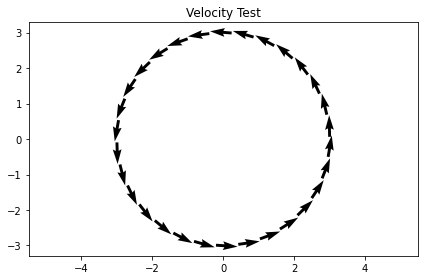

In [78]:
plt.close()
fig, ax = plt.subplots()
plt.quiver(circle_path[1:-1:10, 0], circle_path[1:-1:10, 1], vel_test[::10, 0], vel_test[::10, 1])
plt.axis('equal')
plt.title('Velocity Test')
plt.tight_layout()
plt.show()

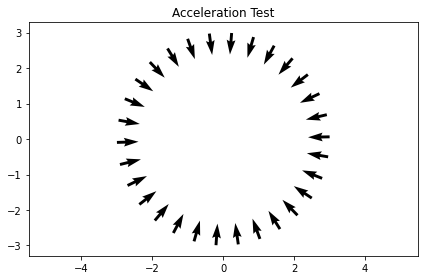

In [79]:
plt.close()
fig, ax = plt.subplots()
plt.quiver(circle_path[1:-1:10, 0], circle_path[1:-1:10, 1], acc_test[::10, 0], acc_test[::10, 1])
plt.axis('equal')
plt.title('Acceleration Test')
plt.tight_layout()
plt.show()

In [80]:
print('Computed circumference: {:.3f} Analytical circumference: {:.3f}'.format(np.sum(arc_test) + arc_test[0], 
                                                                               2*np.pi*3))

Computed circumference: 18.849 Analytical circumference: 18.850


In [88]:
# Curvature should be the reciprocal of the radius
print(np.allclose(crv_test, crv_test[0]))
print(1/crv_test[0])
print(1/curvature(circle_path[::-1], arc_test)[0])

True
3.0001656031548385
-3.0001656031548287


In [ ]:
def neutral_axis_displacement(k):
    # Returns the maximum distance from the neutral axis for a curved section with curvature k
    # TODO saying the neutral axis is always in the center of the beam is not exactly correct and I'm not sure how
    # big the error is at this moment at most factor of 2 error in stress
    return np.ones_like(k) * t/2

def flexural_strain(k0, k1, y):
    # TODO make sure the signs are correct, especially the denominator
    return (k0 - k1) * y / (1 - k0*y)

def tensile_strain(s0, s1):
    return (s1 - s0) / s0

In [ ]:
def stress(r0, r1):
    s0 = arc_length(r0)
    s1 = arc_length(r1)
    k0 = curvature(r0, s0)
    k1 = curvature(r1, s1)
    
    return np.abs(flexural_strain(k0, k1, neutral_axis_displacement(k1))) +
           E * np.abs(tensile_strain(s0, s1)) +
           keep_out_penalty * (keep_out_check(r0, shaft_center, shaft_radius) +
                               keep_out_check(r1, shaft_center, shaft_radius) +
                               keep_out_check(r0, neutral_roller_center, roller_radius) +
                               keep_out_check(r1, deflected_roller_center, roller_radius))

def stress_objective_func(x):
    # x is the optimization parameters
    # x[-1] is the fixed end position scalar
    # x[-2] it the rolling end position scalar
    # the next n elements are the x-components of the neutral spring
    # the next n elements are the y-components of the netural spring
    # the next n elements are the x-components of the deflected spring
    # the next n elements are the y-components of the deflected spring
    r0 = np.zeros(n+2, 2)
    r0[0] = fixed_end(x[-1])
    r0[-1] = rolling_end_neutral(x[-2])
    r0[1:-1, 0] = x[:n]
    r0[1:-1, 1] = x[n:2*n]
    
    r1 = np.copy(r0)
    r1[-1] = rolling_end_deflected(x[-2])
    r1[1:-1, 0] = x[2*n, 3*n]
    r1[1:-1, 1] = x[3*n, 4*n]
    
    return np.max(stress(r0, r1))

In [ ]:
bounds = [None] * 4*n + [(0, 1)] * 2

solution = minimize(stress_objective_func, x0, bounds=bounds)

In [ ]:
# TODO test to make sure all of the functions work as expected
# TODO plot the results of the optimization
# TODO export the solution into an onshape friendly format